<a href="https://colab.research.google.com/github/pinkdolphin11/ESAA/blob/main/5_27_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**04. 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측**

[LinearRegression 클래스 - Ordinary Least Square]

예측값과 실제 값의 RSS(Residual Sum of Squares)를 최소화해서 OLS(Ordinary Least Square) 추정 방식으로 구현한 클래스. fit() 메서드로 X, y 배열을 입력받으면 회귀계수(Coefficients)인 W를 coef_ 속성에 저장.


> class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

* 입력 파라미터
  * fit_intercept : 불린 값. default=True. intercept(절편) 값을 계산할지 말지 지정. False로 지정하면 intercept가 사용되지 않고 0으로 지정됨.
  * normalize : 불린 값. default=False. fit_intercept=False인 경우 무시됨. True이면 회귀를 수행하기 전에 입력 데이터 세트를 정규화.

* 속성
  * coef_ : fit() 메서드를 수행했을 때 회귀계수가 배열 형태로 저장하는 속성. Shape는 (Target 값 개수, 피처 개수).
  * intercept_ : intercept 값

OLS 기반 회귀계수 계산은 입력 피처의 독립성에 많은 영향을 받는다. 피처 간의 상관관계가 매우 높은 경우 분산이 커져서 오류에 민감해지는 현상을 다중 공선성(multi-collinearity) 문제라고 한다. 일반적으로 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용한다. 매우 많은 피처가 다중 공선성 문제를 가지고 있다면 PCA를 통한 차원 축소도 고려해 볼 수 있다.

[회귀 평가 지표]

실제 값과 회귀 예측값의 차이 값을 기반으로 한 지표가 중심. 오류의 절댓값 평균이나 제곱, 또는 제곱한 뒤 다시 루트를 씌운 평균값을 구함.

* MAE : Mean Absolute Error. 실제 값과 예측값의 차이를 절댓값으로 변환해 평균 계산
* MSE : Mean Squared Error. 실제 값과 예측값의 차이를 제곱해 평균 계산
* RMSE : Root Mean Squared Error. MSE에 루트를 씌운 값. MSE는 오류의 제곱이므로 실제 오류 평균보다 더 커지는 특성이 있음.
* R^2 : 분산 기반으로 예측 성능 평가. 실제 값의 분산 대비 예측값의 분산 비율. 1에 가까울수록 예측 정확도가 높음.

각 평가 방법에 대한 사이킷런의 API 및 cross_val_score나 GridSearchCV에서 평가 시 사용되는 scoring 파라미터 적용 값

* MAE : metrics.mean_absolute_error, 'neg_mean_absolute_error'
* MSE : metrics.mean_squared_error, 'neg_mean_squared_error'
* R^2 : metrics.r2_score, 'r2'

Scoring 함수에 회귀 평가 지표를 적용할 때 유의할 점이 있다. 예를 들어 'neg_mean_absolute_error'는 Negative(음수) 값을 가지는데, MAE는 절댓값의 합이므로 음수가 될 수 없다. Scoring 함수에 음수값을 반환하는 이유는 사이킷런의 Scoring 함수가 score 값이 클수록 좋은 평가 결과로 자동 평가하기 때문이다. 그런데 실제 값과 예측값의 오류 차이를 기반으로 하는 회귀 평가 지표의 경우 값이 커지면 오히려 나쁜 모델이라는 의미이므로 이를 Scoring 함수에 일반적으로 반영하려면 보정이 필요하다. 따라서 -1을 원래의 평가 지표 값에 곱해서 음수를 만들어 작은 오류 값이 더 큰 숫자로 인식되게 한다.

[LinearRegression을 이용해 보스턴 주택 가격 회귀 구현]

In [ ]:
#데이터 세트 로드, DataFrame으로 변경

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

#boston 데이터 세트 로드
boston=load_boston()

#boston 데이터 세트 DataFrame 변환
bostonDF=pd.DataFrame(boston.data,columns=boston.feature_names)

#boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가
bostonDF['PRICE']=boston.target
print('Boston 데이터 세트 크기:',bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


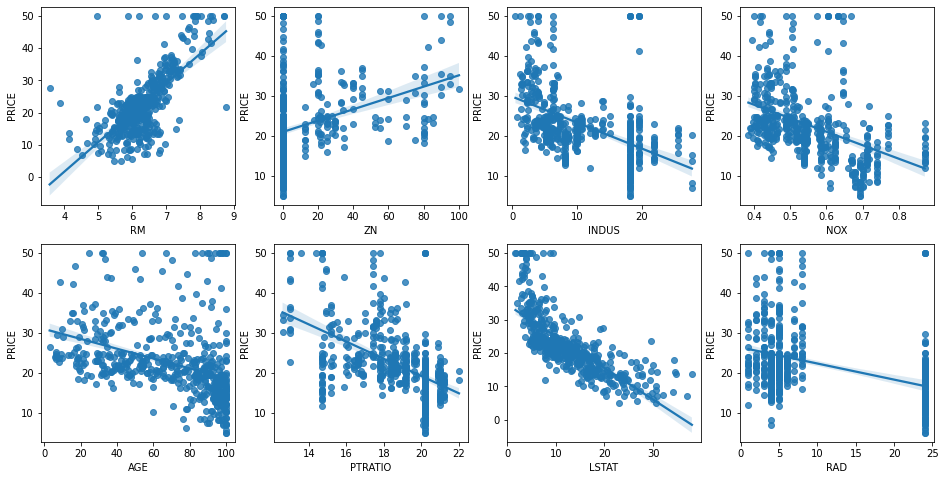

In [ ]:
#각 칼럼이 회귀 결과에 미치는 영향 시각화
#'RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD' 8개 칼럼에 대해 값이 증가할수록 PRICE 값이 어떻게 변하는지 확인

#2개의 행과 4개의 열을 가진 subplots 이용. axs는 4x2개의 ax를 가짐
fig,axs=plt.subplots(figsize=(16,8),ncols=4,nrows=2)
lm_features=['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
  row=int(i/4)
  col=i%4
  #seaborn의 regplot을 이용해 산점도와 선형회귀직선 함께 표현
  sns.regplot(x=feature,y='PRICE',data=bostonDF,ax=axs[row][col])

#결과 : RM(방 개수)은 Positive Linearity가 가장 크다. 방의 크기가 클수록 가격이 증가한다. LSTAT(하위 계층의 비율)는 Negative Linearity가 가장 크다. LSTAT이 적을수록 PRICE가 증가한다.

In [ ]:
#LinearRegression 클래스를 이용해 보스턴 주택 가격의 회귀 모델 만들기

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train,X_test,y_train,y_test=train_test_split(X_data,y_target,test_size=0.3,random_state=156)

#선형 회귀 OLS로 학습/예측/평가 수행
lr=LinearRegression()
lr.fit(X_train,y_train)
y_preds=lr.predict(X_test)
mse=mean_squared_error(y_test,y_preds)
rmse=np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse,rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test,y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [ ]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:',np.round(lr.coef_,1))

절편 값: 40.995595172164755
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [ ]:
#coef_ 속성은 회귀계수 값만 가지고 있으므로 이를 피처별 회귀계수 값으로 다시 매핑하고 높은 값 순서대로 출력

#회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff=pd.Series(data=np.round(lr.coef_,1),index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [ ]:
#5개의 폴드 세트에서 cross_val_score()를 이용해 교차 검증으로 MSE와 RMSE를 측정

from sklearn.model_selection import cross_val_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr=LinearRegression()

#cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 RMSE 구함
neg_mse_scores=cross_val_score(lr,X_data,y_target,scoring='neg_mean_squared_error',cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

#cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores:',np.round(neg_mse_scores,2))
print('5 folds의 개별 RMSE scores:',np.round(rmse_scores,2))
print('5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE : 5.829
